<a href="https://colab.research.google.com/github/kaywenger/CS146-Bayesian-Statistics-Python/blob/master/CS146_LBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Location-Based Assignment: Price Modeling of Grocery Products
## CS146 Modern Computational Statistics, Minerva Schools
### Kay Wenger

# Overview
The goal of this project is to model the cost of groceries in different neighbourhoods in Buenos Aires and Taipei based on student-collected data in both cities, and assess the impact of factors such as store brand and geographical location. This project approaches this task using Bayesian inference, combining prior knowledge with the observed data in order to arrive at a posterior estimate.

Data was collected from a variety of grocery stores around Buenos Aires and Taipei, as assigned by Prof. Scheffler, and entered into the same Google Form. Data was meant to be entered in a standardized format of KG or L, with all prices in Argentinian Pesos, with 2 New Taiwan Dollar to every a Argentinian peso. However, data cleaning is performed in order to ensure standardization. 

This project is organized as follows: First, I clean the data, including data standardization and assessment for outliers. Next, I build the model, justifying choices for the prior probability distribution and the likelihood distribution. Lastly,  I assess outcomes from the model, discuss means and variances of outcomes, compare whether meaningful inference can be made between location multiplier values for a neighbourhood, and the average price of rent in that neighbourhood. 

In [0]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as sts
import pystan
import matplotlib.pyplot as plt
%matplotlib inline


# Loading, Cleaning, Preparation Steps
1. Load data in format accessible to others
2. Examine data, view, print, ensure proper loading
3. Rename variables to make data more interpretable
4. Create new variables based on variables needed for model (translate grocery store address into neighbourhood)
5. Normalize prices (i.e make all relative to per KG or per L)
6. Clean data: check for errors, NA, etc. 



# Load & Examine data


In [3]:
pathtoCsv = r'https://docs.google.com/spreadsheets/d/e/2PACX-1vTFnLUAKF5KSBQFU2gX5jtfnZSMN8oWljghvS1rTGczMtQi55NNc2cNdtaysmE2ehjSDm2JD443Stx9/pub?output=csv'
df = pd.read_csv(pathtoCsv, encoding = 'utf8')
#df.info()
df.head(len(df))[df.columns[0:]]


,Timestamp,Email Address,Your name,Grocery store,Grocery store street address,Neighbourhood Grouping 1,Neighbourhood Grouping 2,Product 1 quantity (kg),Product 1 price,Normalized Price,Product 2 quantity (kg),Product 2 price,Normalized Price.1,Product 3 quantity (kg),Product 3 price,Normalized Price.2,Average Price,Product 1 quantity (kg).1,Product 1 price.1,Normalized Price.3,Product 2 quantity (kg).1,Product 2 price.1,Normalized Price.4,Product 3 quantity (kg).1,Product 3 price.1,Normalized Price.5,Product 1 quantity (kg).2,Product 1 price.2,Normalized Price.6,Product 2 quantity (kg).2,Product 2 price.2,Normalized Price.7,Product 3 quantity (kg).2,Product 3 price.2,Normalized Price.8,Product 1 quantity (kg).3,Product 1 price.3,Normalized Price.9,Product 2 quantity (kg).3,Product 2 price.3,...,Normalized Price.16,Product 3 quantity (kg).5,Product 3 price.5,Normalized Price.17,Product 1 quantity (liters),Product 1 price.6,Normalized Price.18,Product 2 quantity (liters),Product 2 price.6,Normalized Price.19,Product 3 quantity (liters),Product 3 price.6,Normalized Price.20,Product 1 quantity (kg).6,Product 1 price.7,Normalized Price.21,Product 2 quantity (kg).6,Product 2 price.7,Normalized Price.22,Product 3 quantity (kg).6,Product 3 price.7,Normalized Price.23,Product 1 quantity (count),Product 1 price.8,Normalized Price.24,Product 2 quantity (count),Product 2 price.8,Normalized Price.25,Product 3 quantity (count),Product 3 price.8,Normalized Price.26,Product 1 quantity (kg).7,Product 1 price.9,Normalized Price.27,Product 2 quantity (kg).7,Product 2 price.9,Normalized Price.28,Product 3 quantity (kg).7,Product 3 price.9,Normalized Price.29
0,3/2/2020 19:09:54,antoniostark@minerva.kgi.edu,Antonio Stark,Wellcome,"Wellcome, No. 145, Section 1, Heping East Road...",Daan,Taipei,0.600000,198.00,330.000000,0.400000,138.00,345.000000,1.200000,478.00,398.333333,357.777778,0.140000,20.00,142.857143,NaN,NaN,#DIV/0!,NaN,NaN,NaN,0.500000,158.00,316.000000,0.500000,118.00,236.000000,0.500000,136.00,272.000000,0.600000,118.00,196.666667,1.000000,130.00,...,183.200000,1.000000,112.66,112.660000,0.100000,17.94,179.400000,0.100000,18.28,182.800000,0.100000,17.86,178.600000,0.010000,16.26,1626.000000,0.100000,170.00,1700.000000,0.100000,254.40,2544.000000,10.00,190.00,19.000000,10.00,96.00,9.600000,10.0,158.00,15.8,0.160000,198.00,1237.500000,0.250000,158.00,632,0.100,50.00,500.000000
1,3/2/2020 23:33:15,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Carrefour,"Carrefour Market, Av. Corrientes 1160, 1043 CA...",Retiro,Retiro,1.000000,69.90,69.900000,1.000000,86.00,86.000000,1.000000,50.00,50.000000,68.633333,1.000000,94.90,94.900000,NaN,NaN,#DIV/0!,NaN,NaN,NaN,1.000000,84.90,84.900000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,26.00,26.000000,1.000000,55.00,...,61.000000,1.000000,54.50,54.500000,1.000000,40.25,40.250000,1.000000,51.90,51.900000,1.000000,218.50,218.500000,1.000000,545.00,545.000000,1.000000,525.00,525.000000,1.000000,680.00,680.000000,1.00,9.83,9.830000,1.00,9.17,9.170000,1.0,10.25,10.25,1.000000,239.90,239.900000,1.000000,304.90,304.9,NaN,NaN,NaN
2,3/2/2020 23:37:17,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Supermercados Día,"Supermercados Día, Av. Corrientes 3534, C1194 ...",Almagro,Almagro,1.000000,74.99,74.990000,NaN,NaN,NaN,NaN,NaN,NaN,24.996667,NaN,NaN,NaN,NaN,NaN,#DIV/0!,NaN,NaN,NaN,1.000000,92.99,92.990000,1.000000,92.99,92.990000,NaN,NaN,NaN,1.000000,34.99,34.990000,NaN,NaN,...,67.980000,1.000000,49.99,49.990000,1.000000,52.49,52.490000,1.000000,40.25,40.250000,1.000000,68.99,68.990000,1.000000,489.98,489.980000,1.000000,497.45,497.450000,1.000000,532.90,532.900000,1.00,9.83,9.830000,1.00,9.17,9.170000,1.0,11.33,11.33,1.000000,312.90,312.900000,NaN,NaN,NaN,NaN,NaN,NaN
3,3/3/2020 20:18:11,dennis.antela@minerva.kgi.edu,Dennis Antela Martinez,Jumbo,"Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Ai...",Palermo,Palermo,1.000000,80.00,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.666667,1.000000,84.00,84.000000,NaN,NaN,#DIV/0!,NaN,NaN,NaN,

# Renaming columns to improve clarity

In [25]:
# Create list of product names in order of items inputted into Google Sheets (df) from Google Form
# Unfortunately I ended up having to do other manual changes in the spreadsheet so this became no longer relevant. 

product_list = [
                    'Timestamp', 'Student Email', 'Student Name', 'Store Name', 'Store Address', 'Neighbourhood Grouping 1', 'Neighbourhood Grouping 2',
                     'ApplesQ1', 'ApplesP1', 'ApplesQ2', 'ApplesP2', 'ApplesQ3', 'ApplesP3', 
                     'BananasQ1', 'BananasP1', 'BananasQ2', 'BananasP2', 'BananasQ3', 'BananasP3',
                     'TomatoesQ1', 'TomatoesP1', 'TomatoesQ2', 'TomatoesP2', 'TomatoesQ3', 'TomatoesP3', 
                     'PotatoesQ1', 'PotatoesP1', 'PotatoesQ2', 'PotatoesP2', 'PotatoesQ3', 'PotatoesP3',
                     'FlourQ1', 'FlourP1', 'FlourQ2', 'FlourP2', 'FlourQ3', 'FlourP3',
                     'RiceQ1', 'RiceP1', 'RiceQ2', 'RiceP1', 'RiceQ3', 'RiceP3', 
                     'MilkQ1', 'MilkP1', 'MilkQ2', 'MilkP2', 'MilkQ3', 'MilkP3', 
                     'ButterQ1', 'ButterP1', 'ButterQ2', 'ButterP2', 'ButterQ3', 'ButterP3',
                     'EggsQ1', 'EggsP1', 'EggsQ2', 'EggsP2', 'EggsQ3', 'EggsP3',
                     'ChickenQ1', 'ChickenP1', 'ChickenQ2', 'ChickenP2', 'ChickenQ3', 'ChickenP3']

print(product_list)
df.columns = product_list

['Timestamp', 'Student Email', 'Student Name', 'Store Name', 'Store Address', 'Neighbourhood Grouping 1', 'Neighbourhood Grouping 2', 'ApplesQ1', 'ApplesP1', 'ApplesQ2', 'ApplesP2', 'ApplesQ3', 'ApplesP3', 'BananasQ1', 'BananasP1', 'BananasQ2', 'BananasP2', 'BananasQ3', 'BananasP3', 'TomatoesQ1', 'TomatoesP1', 'TomatoesQ2', 'TomatoesP2', 'TomatoesQ3', 'TomatoesP3', 'PotatoesQ1', 'PotatoesP1', 'PotatoesQ2', 'PotatoesP2', 'PotatoesQ3', 'PotatoesP3', 'FlourQ1', 'FlourP1', 'FlourQ2', 'FlourP2', 'FlourQ3', 'FlourP3', 'RiceQ1', 'RiceP1', 'RiceQ2', 'RiceP1', 'RiceQ3', 'RiceP3', 'MilkQ1', 'MilkP1', 'MilkQ2', 'MilkP2', 'MilkQ3', 'MilkP3', 'ButterQ1', 'ButterP1', 'ButterQ2', 'ButterP2', 'ButterQ3', 'ButterP3', 'EggsQ1', 'EggsP1', 'EggsQ2', 'EggsP2', 'EggsQ3', 'EggsP3', 'ChickenQ1', 'ChickenP1', 'ChickenQ2', 'ChickenP2', 'ChickenQ3', 'ChickenP3']


# Rename variables to make data more interpretable
# Create new variables based on variables needed for model (translate grocery store address into neighbourhood)
# Normalize prices (i.e make all relative to per KG or per L)

In [6]:
# Manual data cleaning in Excel: Divide P1 by Q1 for each product, P2/Q2, and P3/Q3 = N1, N2, N3 for each product. 
# Remove NAs
# Add neighbourhood1 column for neighbourhood listed by Prof. Scheffler in Spreadsheet for Buenos Aires, and Taipei neighbourhood by Google Maps district listing. 
# Add neighbourhood2 column for the same Buenos Aires neighbourhoods, and Taipei locations by Taipei label  rather than Taipei neighbourhood label. 



,Timestamp,Email Address,Your name,Grocery store,Grocery store street address,Neighbourhood Grouping 1,Neighbourhood Grouping 2,ApplesQ1,ApplesP1,ApplesN1,ApplesQ2,ApplesP2,ApplesN2,Product 3 quantity (kg),Product 3 price,ApplesN3,Average Price,Product 1 quantity (kg),Product 1 price,BananasN1,Product 2 quantity (kg),Product 2 price,BananasN2,Product 3 quantity (kg).1,Product 3 price.1,BananasN3,Product 1 quantity (kg).1,Product 1 price.1,TomatoesN1,Product 2 quantity (kg).1,Product 2 price.1,TomatoesN2,Product 3 quantity (kg).2,Product 3 price.2,TomatoesN3,Product 1 quantity (kg).2,Product 1 price.2,PotatoesN1,Product 2 quantity (kg).2,Product 2 price.2,...,RiceN2,Product 3 quantity (kg).5,Product 3 price.5,RiceN3,Product 1 quantity (liters),Product 1 price.5,MilkN1,Product 2 quantity (liters),Product 2 price.5,MilkN2,Product 3 quantity (liters),Product 3 price.6,MilkN3,Product 1 quantity (kg).5,Product 1 price.6,ButterN1,Product 2 quantity (kg).5,Product 2 price.6,ButterN2,Product 3 quantity (kg).6,Product 3 price.7,ButterN3,Product 1 quantity (count),Product 1 price.7,EggsN1,Product 2 quantity (count),Product 2 price.7,EggsN2,Product 3 quantity (count),Product 3 price.8,EggsN3,Product 1 quantity (kg).6,Product 1 price.8,ChickenN1,Product 2 quantity (kg).6,Product 2 price.8,ChickenN2,Product 3 quantity (kg).7,Product 3 price.9,ChickenN3
0,3/2/2020 19:09:54,antoniostark@minerva.kgi.edu,Antonio Stark,Wellcome,"Wellcome, No. 145, Section 1, Heping East Road...",Daan,Taipei,0.600000,198.00,330.000000,0.400000,138.00,345.000000,1.200000,478.00,398.333333,357.777778,0.140000,20.00,142.857143,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,158.00,316.000000,0.500000,118.00,236.000000,0.500000,136.00,272.000000,0.600000,118.00,196.666667,1.000000,130.00,...,183.200000,1.000000,112.66,112.660000,0.100000,17.94,179.400000,0.100000,18.28,182.800000,0.100000,17.86,178.600000,0.010000,16.26,1626.000000,0.100000,170.00,1700.000000,0.100000,254.40,2544.000000,10.00,190.00,19.000000,10.00,96.00,9.600000,10.0,158.00,15.8,0.160000,198.00,1237.500000,0.250000,158.00,632,0.100,50.00,500.000000
1,3/2/2020 23:33:15,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Carrefour,"Carrefour Market, Av. Corrientes 1160, 1043 CA...",Retiro,Retiro,1.000000,69.90,69.900000,1.000000,86.00,86.000000,1.000000,50.00,50.000000,68.633333,1.000000,94.90,94.900000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,84.90,84.900000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,26.00,26.000000,1.000000,55.00,...,61.000000,1.000000,54.50,54.500000,1.000000,40.25,40.250000,1.000000,51.90,51.900000,1.000000,218.50,218.500000,1.000000,545.00,545.000000,1.000000,525.00,525.000000,1.000000,680.00,680.000000,1.00,9.83,9.830000,1.00,9.17,9.170000,1.0,10.25,10.25,1.000000,239.90,239.900000,1.000000,304.90,304.9,NaN,NaN,NaN
2,3/2/2020 23:37:17,halkenjo@minerva.kgi.edu,Johannes Halkenhaeusser,Supermercados Día,"Supermercados Día, Av. Corrientes 3534, C1194 ...",Almagro,Almagro,1.000000,74.99,74.990000,NaN,NaN,NaN,NaN,NaN,NaN,24.996667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,92.99,92.990000,1.000000,92.99,92.990000,NaN,NaN,NaN,1.000000,34.99,34.990000,NaN,NaN,...,67.980000,1.000000,49.99,49.990000,1.000000,52.49,52.490000,1.000000,40.25,40.250000,1.000000,68.99,68.990000,1.000000,489.98,489.980000,1.000000,497.45,497.450000,1.000000,532.90,532.900000,1.00,9.83,9.830000,1.00,9.17,9.170000,1.0,11.33,11.33,1.000000,312.90,312.900000,NaN,NaN,NaN,NaN,NaN,NaN
3,3/3/2020 20:18:11,dennis.antela@minerva.kgi.edu,Dennis Antela Martinez,Jumbo,"Jumbo, Av. Santa Fe 4950, C1425 BHY, Buenos Ai...",Palermo,Palermo,1.000000,80.00,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.666667,1.000000,84.00,84.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,99.00,99.000000,1.000000,139.00,139.000000,1.000000,109.00,109.000000,1.000000,44.00,44.000000,1.000000,26.00,...,53.500000,1.000000,54.50,54.500000,1.000000,69.00,69.000000,1.000000,60.00,60.000000,1.000000,65.00,65.000000,0.200000,125.00,625.000000,0.200000,130.00,650.000000,0.200000,94.00,470.000000,6.00,92.9

# Create new dataframe to re-organize information for use


In [89]:
# Re-organize to make into panel data, price = N1, N2, N3 for each product, for each store. 
# Unfortunately, I was not able to re-organize the data in the way needed via Python, despite many attempts. 
# I spent ~ 3 hours copying each item by hand into a new spreadsheet format. I acknowedlge there may be human error in data introduced. 

pathtoCsv = r'https://docs.google.com/spreadsheets/d/e/2PACX-1vQXTZLeQqgXUKcMihAyesJmzmdfqSPYXD8BS4pRMWzgru6xrMremQTNmUOcujm2b35w1LmzS-nR6EkH/pub?output=csv'
df2 = pd.read_csv(pathtoCsv, encoding = 'utf8')
df2.head(len(df2))[df2.columns[0:]]




,Product,Store,Neighbourhood1,Neighbourhood2,Price
0,Apples,Wellcome,Daan,Taipei,330.000000
1,Apples,Wellcome,Daan,Taipei,345.000000
2,Apples,Wellcome,Daan,Taipei,398.333333
3,Apples,Supermercados Día,Almagro,Almagro,74.990000
4,Apples,Jumbo,Palermo,Palermo,80.000000
...,...,...,...,...,...
847,Chicken,Carrefour,Palermo,Palermo,198.900000
848,Chicken,Carrefour,Palermo,Palermo,264.900000
849,Chicken,Carrefour,Palermo,Palermo,124.567568
850,Chicken,Carrefour,Palermo,Palermo,204.895349


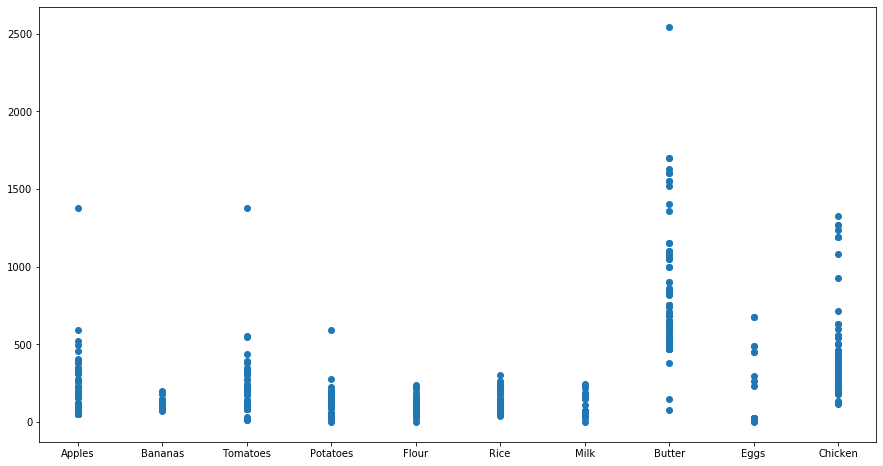

In [79]:
# Plot list to assess distribution of prices per product type
plt.figure(figsize=(15,8))
plt.scatter(df2['Product'],df2['Price'])
plt.show()

# Check for data which seems spurious
# Staple goods of flour, rice, milk seem generally consistent
# Tomatoes and apples seem consistent, with two outliers
# Chicken varies from to NTD 200, or $6 USD, to NTD 1500, or $50, per kg
# Butter is even more extremely dispersed than Chicken, with a potential 2500 NTD or $80 USD for 1 KG of butter. 




# Pruning Data
- I choose to prune the top outliers for Apples and Tomatoes, pruning off > 700
- I prune potatoes > 500
- I prune butter > 2000 but not below that, as there are too many data points around 1500 for it to be one person's data entry mistake. Additionally, it is possible to have very expensive butter in Taipei (1750 NTD or 60 USD per 1kg, or 6 USD per 100 g) and data is distributed evenly. 
- I look more closely at eggs, since 500 NTD (16 USD/egg) seems extreme, even 200 NTD (3/egg ofr 30 USD for 10 eggs). I assume students may have counted by gram rather than egg. Raw data shows an average of 10-20 NTD per egg, with extreme outliers in the several hundreds, all from the same 2 Taipei stores. It appears Egg data for these two taipei stores has also been duplicated, doubling the number of erronious data. Therefore, I prune data > 50 NTD 
- For chicken, data is widely distributed, and high-prices recorded from one store location match with high-prices from that brand in another store. Additionally, the data clusers somewhat and potentially suggests a difference in Taipei vs. Buenos Aires prices. For these reasons, we take the data as-is rather than pruning. 

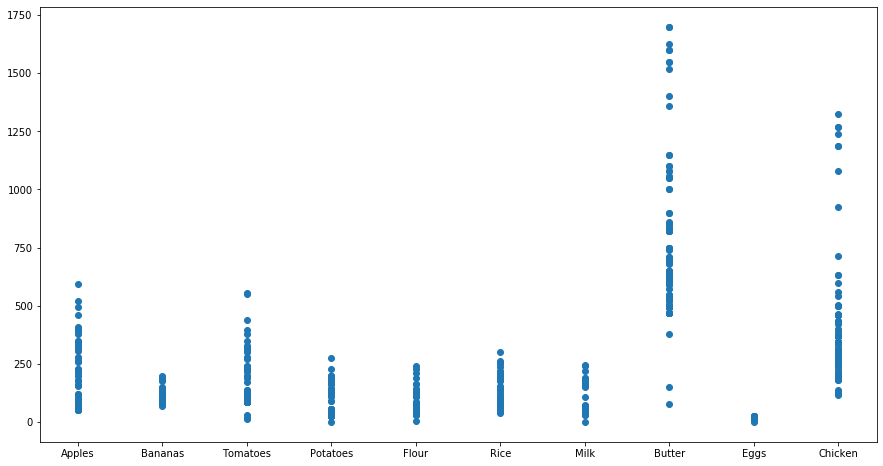

In [90]:
df2 = df2.drop(df2[(df2['Price'] > 700) & (df2['Product'] == "Apples")].index)
df2 = df2.drop(df2[(df2['Price'] > 700) & (df2['Product'] == "Tomatoes")].index)
df2 = df2.drop(df2[(df2['Price'] > 500) & (df2['Product'] == "Potatoes")].index)
df2 = df2.drop(df2[(df2['Price'] > 2000) & (df2['Product'] == "Butter")].index)
df2 = df2.drop(df2[(df2['Price'] > 50) & (df2['Product'] == "Eggs")].index)

plt.figure(figsize=(15,8))
plt.scatter(df2['Product'],df2['Price'])
plt.show()



# Model Creation



# Model Choices
## Parameters
This paper aims to model a "base price" per product, a "multiplier effect" that a grocery store's brand may have on that price, and a "multiplier effect" that a neighbourhood may have on that product. We consider separated Taipei neighbourhoods and separated Buenos Aires neighbourhoods in the same model, as well as model with Buenos Aires neighbourhoods separated and Taipei data listed as one category of "Taipei", and lastly, a model considering only Buenos Aires neighbourhoods. 

## Distribution and Likelihood
We assume grocery store prices will centre around one mean, and follow a normal distribution. This pricing model is represented by: 

$Price =  Normal(base price * store multiplier * location multiplier)$

We assume our collected data, and therefore likelhood, follow a normal distribution. 


## Priors
We consider priors for the base price, and each of the multipliers.

Base price: cauchy(200,2)

For the base price, we set the prior as a cauchy distribution, which follows the same bell curve as a normal but with wider tails. We set the curve to only give us values >0. Setting a mean is a challenge with a widely dispersed dataset, we cannot simply take the mean of the data we have, as we should not use our data to inform our prior.  We estimate a median of 200 NTD. We estimate an scale term greater than the "standard normal" for cauchy, setting it to 2 instead of 1 to broaden tails.  

Multipliers: gamma(2, 0.8)

For store multipliers, based on our experience living in both Taipei and Buenos aires for 3-4 months each, and shopping in various grocery stores as well as visiting and living in different districts in the city, our prior knowledge says that while prices of some stores in an area may change by neighbourhood, for example, more organic food stores in some than others, all grocery stores in these assignments in both cities were large chain stores, which would not price differently by neighbourhood due to logistical reasons, and, do not price differently to another due to being in the same low-cost supermarket category and competiting with one another. Therefore, we set priors for these multipliers to have the highes probability of being "1," (parameters< 2, 0.8), that is, to have no effect on prices. We use the gamma distribution as it's support and error are both >0. 




# Stan Model

In [0]:
# Tried to run Stan model below and getting errors about my variables (ex, Neighbourhod1)  being neither int nor float nor list/array thereof
# Was stuck on how to do this, guidance taken from Barbara Costa
# Creating a set of numerical values and a set of categorical values to address this, stored as dictionaries

for i in df2.columns:
    if i != "Price":
        df2[i] = df2[i].astype('category')

D_Product = dict(enumerate(df2['Product'].cat.categories))
D_Neighbourhood1 = dict(enumerate(df2['Neighbourhood1'].cat.categories))
D_Store = dict(enumerate(df2['Store'].cat.categories))

C_columns = df2.select_dtypes(['category']).columns
df2[C_columns] = df2[C_columns].apply(lambda x: x.cat.codes)

# Address issue in Stan where index cannot be 0 for multiplying data entries
#("  raise ValueError("Warmup samples must be greater than 0 when adaptation is enabled (`adapt_engaged=True`)")")
# Add 1 to every value

df2['Neighbourhood1'] = df2["Neighbourhood1"].apply(lambda x: x+1)
df2['Store'] = df2["Store"].apply(lambda x: x+1)
df2['Product'] = df2["Product"].apply(lambda x: x+1)

In [0]:
#Stan code to be passed into the StanModel later
stan_code = """

data {
    int<lower=1> Row_Count;                         
    real<lower=0> Price[Row_Count];  
    int<lower=0> Neighbourhood1[Row_Count]; 
    int<lower=1> Neighbourhood1_Count; 
    int<lower=1> Store_Count; 
    int<lower=0> Store[Row_Count];   
    int<lower=0> Product[Row_Count];              
    int<lower=1> Product_Count;    
    real<lower=0> loc;           //cauchy prior 
    real<lower=0> scale;         //cauchy prior 
    real<lower=0> alpha;         // gamma prior 
    real<lower=0> beta;          // gamma prior 
    
}

parameters {
    real<lower=0> Neighbourhood_Multiplier[Neighbourhood1_Count];
    real<lower=0> Store_Multiplier[Store_Count];
    real<lower=0> Price_Multiplier[Product_Count];
    real<lower=0> Error;
}

model {
    Neighbourhood_Multiplier ~ gamma(alpha, beta);  // prior over lambda
    Store_Multiplier ~ gamma(alpha, beta);
    Price_Multiplier ~ cauchy(loc,scale);
    Error ~ gamma(alpha,beta);
    
    for(x in 1:Row_Count){
        Price[x] ~ normal(Price_Multiplier[Product[x]] * Neighbourhood_Multiplier[Neighbourhood1[x]]*Store_Multiplier[Store[x]] ,Error); 
    }   
}

"""

In [93]:
stan_model = pystan.StanModel(model_code=stan_code)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7314c233335243980f0f897a00de594f NOW.


In [0]:
#Defing dictionary for passing into Stan model 
input_data = {
    "Price" : df2["Price"].tolist(),
    "Store" : df2["Store"].tolist(),
    "Neighbourhood1_Count" : len(set(df2["Neighbourhood1"].tolist())),
    "Neighbourhood1" : df2["Neighbourhood1"].tolist(),
    "Product" : df2["Product"].tolist(),
    "Product_Count" : 10, #was 9 but added 1 to each
    "Store_Count" : len(set(df2["Store"].tolist())),
    "Row_Count" : len(df2.index),
    "alpha" : 2,
    "beta" : 0.8,
    "loc" : 200,
    "scale" : 2
}


In [95]:
stan_results = stan_model.sampling(data=input_data)

RuntimeError: ignored

In [87]:
#Extract information from the sampled posterior disttibutions
#and format them into a data frame
posterior_samples = stan_results.extract()
summary = stan_results.summary()
df_summary.head()

NameError: ignored

I have not been able to get my Pystan to run despite many hours of debugging the bugs, and then having Pystan give me new bugs. I have had help from classmates and TAs. COVID is also happening right now and I may not be able to entry my home country soon so everything has been quite crazy and I am submitting this now in case I am not able to update it further. 

If I were able to continue this assignment, I would plot samples of posteriors over the base price for each product, the multiplier for each store and for each neighbourhood, and comment on the mean and variance of base prices, as well as multiplier values (ex, greater than 1 or not). I would then compared regress the multiplier value to the rental prices by neighbourhood with an average of the rental prices near subway stations in those neighbourhoods, and test for significance.  

***note***

I did indeed go to the correct stores and went so far as to purchase some items so I could properly weigh them at home and deduce prices, however, I had not realized we had to take pictures of the stores.